In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pdb

In [3]:
class primacy_model():

    def __init__(self, params_dict):

        '''
        :param float P: peak value of undecayed primacy gradient 
        :param float M: sd of noise added to forward activation
        :param float T: output threshold
        :param float N: sd of selection noise 
        :param int vocab_size: number of items in vocab 
        :param float blank: period of time from end of one item to onset of the next
        :param float R: covert rehearsal rate (items/sec)
        :param float item_presentation_rate: length (sec) that each item is presented
        :param int vocab_size: number of items in vocabulary 
        :param float input_strength: how strongly each input is activated upon presentation 
        :param int list_length: length of each list 
        :param float output_time: time it takes to output a letter
        '''

        self.P = params_dict['P']
        self.M = params_dict['M']
        self.T = params_dict['T']
        self.D = params_dict['D']
        self.N = params_dict['N']
        self.s = params_dict['P']
        self.blank_period = params_dict['blank']
        self.R = params_dict['R']
        self.ipr = params_dict['item_presentation_rate']
        self.vocab_size = params_dict['vocab_size']
        self.input_strength = params_dict['input_strength']
        self.list_length = params_dict['list_length']
        self.output_time = params_dict['output_time']
        self.dt = params_dict['dt']
        
         # inter-onset interval 
        self.IOI = self.ipr + self.blank_period
        self.C = np.floor(max(0, self.R * (self.IOI - .2))) # number of cumulative rehearsals 
        self.omission = -1 
        self.intrusions = 0

        # define number of euler updates for item presentation, ioi, and recalled
        self.euler_updates_item_presentation = int(self.ipr/self.dt)
        self.euler_updates_blank = int(self.blank_period/self.dt)
        self.euler_updates_recalled = int(self.output_time/self.dt)

    def present_list(self, presented_items):

        item_activations = np.zeros(self.vocab_size)
        start_marker = self.s
        self.L = len(presented_items)

        for pos, item in enumerate(presented_items):
            item_inputs = np.zeros(self.vocab_size)
            item_inputs[item] = self.input_strength
            item_activations, start_marker = self.activation_dynamics(item_activations, False, item_inputs, pos, start_marker)
        return item_activations

    def recall_list(self, item_activations, current_list):

        recalled_items = []

        for i in range(self.list_length):

            # add selection noise
            item_act_noisy = item_activations + np.random.default_rng().normal(0, self.N, self.vocab_size)

            # retrieve strongest activated item 
            selected_item = np.argmax(item_act_noisy)
            selected_item_act = np.max(item_act_noisy)       

            # add noise to selected item before comparing to output threshold 
            selected_item_act += np.random.default_rng().normal(0, self.M, 1)[0]

            # check if activation of selected item is greater than the threshold
            if selected_item_act >= self.T:
                recalled_items.append(selected_item)
                # set activation of selected item to 0 to model response suppression 
                item_activations[selected_item] = 0 

            else:
                recalled_items.append(self.omission)

            item_activations = self.activation_dynamics(item_activations, recall_mode=True,
                                                 item_inputs=np.zeros(self.vocab_size))

        return recalled_items

                
    def activation_dynamics(self, item_activations, recall_mode, item_inputs,
                                position=None, start_marker=None):

        # incorporate exponential decay for recall phase
        if recall_mode: 
            for i in range(self.euler_updates_recalled):
                item_activations += -self.D * item_activations * self.dt
            return item_activations 
            
        else: 
            n = np.sum(item_activations>0) # number of items presented 
            presented_item = np.argwhere(item_inputs!=0)[0][0]
            for i in range(self.euler_updates_item_presentation):

                # if the entire list can be rehearsed, then remove exponential decay
                # otherwise incorporate exp decay
                if position < self.C:
                    exponential_decay = np.zeros(self.vocab_size)
                    exponential_decay_sm = 0
                else:
                    exponential_decay = -self.D * item_activations
                    exponential_decay_sm = start_marker*-self.D # decay for start marker 
                
                A = start_marker*(1-n/self.P)
                item_activations += (exponential_decay + (A-item_activations)*item_inputs)*self.dt 
                start_marker += exponential_decay_sm*self.dt

            # incorporate decay effects for inter-item interval 
            # only if cumulative rehearsals are no longer possible
            if position >= self.C:
                for i in range(self.euler_updates_blank):
                    item_activations += -self.D * item_activations * self.dt
                    start_marker += start_marker*-self.D*self.dt

        return item_activations, start_marker

    def simulate_trials(self, num_trials):

        presented_list_storage = np.zeros((num_trials, self.list_length))
        recalled_list_storage = np.zeros((num_trials, self.list_length))

        frac_errors_list = []
        frac_omissions_list = []

        for i in range(num_trials):

            vocab = np.arange(6)

            current_list= np.random.default_rng().choice(vocab, self.list_length, replace=False)

            presented_list_storage[i] = current_list

            item_act = self.present_list(current_list)
            recalled_list = self.recall_list(item_act, current_list)

            for item in recalled_list:
                if item not in current_list and item!=-1:
                    self.intrusions += 1

            recalled_list_storage[i] = recalled_list

        for l in range(self.list_length):

            presented_items_pos_l = presented_list_storage[:, l]
            recalled_items_pos_l = recalled_list_storage[:, l]
            
            frac_errors = np.round(1- np.argwhere(recalled_items_pos_l==presented_items_pos_l).shape[0] / num_trials,2)
            frac_omissions = np.argwhere(recalled_items_pos_l==-1).shape[0] / num_trials
            frac_errors_list.append(frac_errors)
            frac_omissions_list.append(frac_omissions)

        return frac_errors_list, frac_omissions_list

In [6]:
params_dict = {'P':11.5, 'D':0.27, 'T':0.49, 'M':0.74, 'N':0.23, 'vocab_size':6, 'input_strength':50, 
                    'item_presentation_rate':0.4, 'blank':0.1, 'R': 4, 
                    'list_length': 6, 'output_time': 0.5, 'dt':0.005}
PS = primacy_model(params_dict)
fel,fol = PS.simulate_trials(num_trials=10000)

Text(0.5, 0, 'Serial Position')

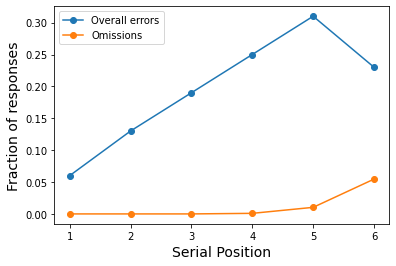

In [ ]:
# Recreating Figure 3 of paper
plt.plot([1,2,3,4,5,6], fel, marker='o', label='Overall errors')
plt.plot([1,2,3,4,5,6], np.array(fol), marker='o', label='Omissions')
plt.legend()
plt.ylabel("Fraction of responses", fontsize=14)
plt.xlabel("Serial Position", fontsize=14)

In [ ]:
class vectorized_primacy_model(primacy_model):

    def __init__(self):
        